In [1]:
import numpy as np
import pandas as pd 
import os
from pathlib import Path
import nibabel as nib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import tarfile

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
! pip install gdown

### Downloading dataset from google drive into our project

In [3]:
import gdown

url = 'https://drive.google.com/file/d/1zix-XyFhYTjlW4CnAnVrC7g0PvcEAbyi/view?usp=drivesdk'
file_id = url.split('/')[-2]
direct_download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

output = 'heart.tar'
gdown.download(direct_download_url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1zix-XyFhYTjlW4CnAnVrC7g0PvcEAbyi&export=download
From (redirected): https://drive.google.com/uc?id=1zix-XyFhYTjlW4CnAnVrC7g0PvcEAbyi&export=download&confirm=t&uuid=5d749c9d-a2f7-43b4-9d03-a6f1709989a8
To: /kaggle/working/heart.tar
100%|██████████| 456M/456M [00:45<00:00, 10.1MB/s]


'heart.tar'

### Extracting data content from .tar file using `tarfile` module and it's method `extractall`

In [4]:
tar_path = "/kaggle/working/heart.tar"

with tarfile.open(tar_path, 'r') as tar:
    tar.extractall('./data')

In [5]:
root = Path("./data/Task02_Heart/imagesTr")
label = Path("./data/Task02_Heart/labelsTr")

In [6]:
# For a given image path, returing it's corresponding label path
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'
    return Path(*parts)

In [7]:
# Finding all Paths that contain 'la' using glob('la*')
sample_paths = list(root.glob("la*"))[:5]
sample_paths

[PosixPath('data/Task02_Heart/imagesTr/la_019.nii.gz'),
 PosixPath('data/Task02_Heart/imagesTr/la_007.nii.gz'),
 PosixPath('data/Task02_Heart/imagesTr/la_026.nii.gz'),
 PosixPath('data/Task02_Heart/imagesTr/la_011.nii.gz'),
 PosixPath('data/Task02_Heart/imagesTr/la_022.nii.gz')]

In [8]:
# Splitting a sample path's parts
parts = list(sample_paths[0].parts)
parts

['data', 'Task02_Heart', 'imagesTr', 'la_019.nii.gz']

In [9]:
# Convert parts to Path
Path(*parts)

PosixPath('data/Task02_Heart/imagesTr/la_019.nii.gz')

In [10]:
sample_path = list(root.glob("la*"))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [11]:
sample_path, sample_path_label

(PosixPath('data/Task02_Heart/imagesTr/la_019.nii.gz'),
 PosixPath('data/Task02_Heart/labelsTr/la_019.nii.gz'))

In [12]:
# Loading images data from disk into proxy images
data = nib.load(sample_path)
label = nib.load(sample_path_label)

# Converting proxy images into Numpy array data using get_fdata method
mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

The axis code **RAS** indicates that:
1. The first axis is from right to left (**R**).
2. The second axis is from anterior to posterior (**A**).
3. The third axis is from superior to inferior (**S**).

In [13]:
# checking the orienation of scans
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [14]:
! pip install celluloid

In [15]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()

camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5)
    camera.snap()

# animation = camera.animate()
# HTML(animation.to_jshtml())

In [16]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    # Min-Max Standardization
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [17]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [18]:
save_root = Path('preprocessed')

# Iterating over all 3D images
for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    # Getting corresponding label path
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    # Make sure that the orientation is RAS
    assert nib.aff2axcodes(data.affine) == ('R', 'A', 'S')
    
    # Loading mri and label images
    mri = nib.load(path_to_mri_data)
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # As the images have padding, we crop 32 pixels from start and the end of images
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    # Normalizing and Standardizing mri_data
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # Splitting data into train and val folders
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Iterating over all 2D slices of a 3D image
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:, :, i]
        mask = label_data[:, :, i]
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        # Creating new directory
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        # Saving array objects(.npy) in the given directory
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

### Now what do we have?

In [19]:
prp_path = "./preprocessed"

print(f"preprocessed: {os.listdir(prp_path)}")
for prp_data in os.listdir(prp_path):
    prp_data_path = os.path.join(prp_path, prp_data)
    print(f"\n{prp_data}: {os.listdir(prp_data_path)}")
    for item in os.listdir(prp_data_path):
        item_path = os.path.join(prp_data_path, item)
        print(f"\n{item}: {os.listdir(item_path)}")
        for sub_item in os.listdir(item_path):
            sub_path = os.path.join(item_path, sub_item)
            print(f"\n{sub_item}:\n{os.listdir(sub_path)}")
            break
        break
    break

preprocessed: ['val', 'train']

val: ['17', '19', '18']

17: ['masks', 'data']

masks:
['9.npy', '5.npy', '36.npy', '118.npy', '12.npy', '67.npy', '3.npy', '60.npy', '78.npy', '116.npy', '46.npy', '64.npy', '65.npy', '72.npy', '79.npy', '57.npy', '110.npy', '14.npy', '115.npy', '62.npy', '34.npy', '44.npy', '47.npy', '87.npy', '81.npy', '17.npy', '50.npy', '42.npy', '51.npy', '106.npy', '32.npy', '103.npy', '16.npy', '4.npy', '117.npy', '109.npy', '70.npy', '26.npy', '77.npy', '53.npy', '30.npy', '59.npy', '18.npy', '27.npy', '35.npy', '31.npy', '111.npy', '58.npy', '0.npy', '83.npy', '88.npy', '24.npy', '41.npy', '6.npy', '108.npy', '63.npy', '45.npy', '15.npy', '7.npy', '66.npy', '102.npy', '96.npy', '90.npy', '8.npy', '101.npy', '114.npy', '11.npy', '75.npy', '71.npy', '55.npy', '33.npy', '20.npy', '56.npy', '2.npy', '85.npy', '1.npy', '92.npy', '82.npy', '112.npy', '94.npy', '29.npy', '76.npy', '40.npy', '10.npy', '52.npy', '19.npy', '99.npy', '21.npy', '25.npy', '91.npy', '69.npy'

In [20]:
path = Path("preprocessed/train/0")
file = '50.npy'
slice_ = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

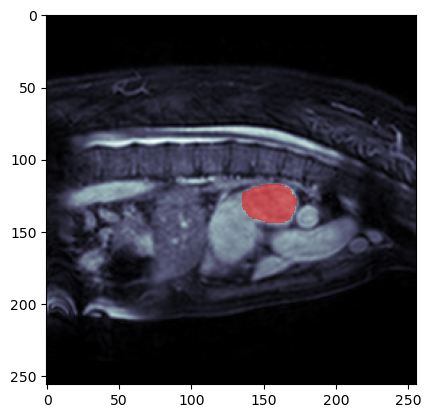

In [21]:
plt.figure()
plt.imshow(slice_, cmap='bone')
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.5, cmap="autumn")

# Dataset

In [22]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slc in slice_path.glob("*.npy"):
                files.append(slc)
        return files
    
    # For a given image path, returing it's corresponding label path
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index('data')] = 'masks'
        return Path(*parts)
    
    def augment(self, slc, mask):
        random_seed = torch.randint(0, int(1e+5), (1, )).item()
        imgaug.seed(random_seed)
        
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slc_aug, mask_aug = self.augment_params(image=slc, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slc_aug, mask_aug
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        
        slc = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slc, maks = self.augment(slc, mask)
            
        return np.expand_dims(slc, 0), np.expand_dims(mask, 0)

In [23]:
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), rotate=(-0.45, 0.45)),
    iaa.ElasticTransformation()
])

In [24]:
path = Path('preprocessed/train')
dataset = CardiacDataset(path, seq)

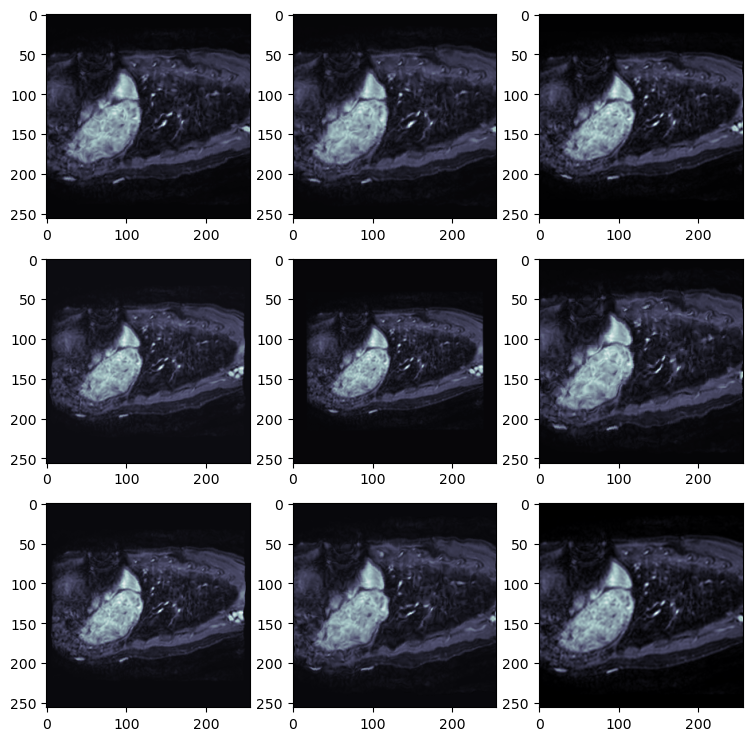

In [25]:
n_cols, n_rows = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 9))

for i in range(n_rows):
    for j in range(n_cols):
        slc, mask = dataset[1]
        mask_ = np.ma.masked_where(mask==0, mask)
        axes[i][j].imshow(slc[0], cmap='bone')
        axes[i][j].imshow(mask_[0], alpha=0.5, cmap='autumn')

# Model: U-NET

In [26]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU()
        )
        
    def forward(self, x):
        return self.step(x)

In [27]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.layer1 = DoubleConv(in_channels=1, out_channels=64)
        self.layer2 = DoubleConv(in_channels=64, out_channels=128)
        self.layer3 = DoubleConv(in_channels=128, out_channels=256)
        
        # Intermediate Layer
        self.layer4 = DoubleConv(in_channels=256, out_channels=512)
        
        # Decoder
        self.layer5 = DoubleConv(in_channels=512+256, out_channels=256)
        self.layer6 = DoubleConv(in_channels=256+128, out_channels=128)
        self.layer7 = DoubleConv(in_channels=128+64, out_channels=64)
        
        # Final Layer
        self.layer8 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x1_m = self.maxpool(x1)
        
        x2 = self.layer2(x1_m)
        x2_m = self.maxpool(x2)
        
        x3 = self.layer3(x2_m)
        x3_m = self.maxpool(x3)
        
        x4 = self.layer4(x3_m)
        
        # Decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        
        return ret

In [28]:
model = UNet()

In [29]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == random_input.shape

In [30]:
train_path = Path('preprocessed/train')
val_path = Path('preprocessed/val')

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [31]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)

In [32]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        
        dice = (2 * counter) / denum
        
        return 1 - dice

In [33]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(),pred.cpu(), mask.cpu(), 'Train')
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Val')
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5
        fig, axes = plt.subplots(1, 2)
        
        axes[0].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axes[0].imshow(mask_, alpha=0.5, cmap='autumn')
        
        axes[1].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0]==0, pred[0][0])
        axes[1].imshow(mask_, alpha=0.5, cmap='autumn')
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [34]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [35]:
checkpoint_callback = ModelCheckpoint(monitor='Val Dice', save_top_k=10, mode='min')

In [36]:
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir='logs'), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=25)

In [37]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [39]:
preds, labels = [], []

for slc, label in tqdm(val_dataset):
    slc = torch.tensor(slc).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slc)
    
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/370 [00:00<?, ?it/s]

In [40]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.)

In [41]:
subject = "./data/Task02_Heart/imagesTs/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()

In [42]:
# model = AtriumSegmentation.load_from_checkpoint('weights/23.ckpt')

In [43]:
# As the images have padding, we crop 32 pixels from start and the end of images
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [44]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slc = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slc).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

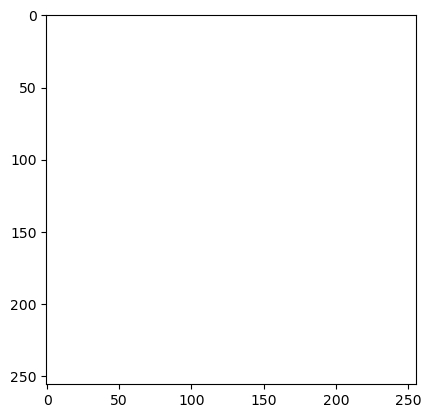

In [45]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask_, alpha=0.5, cmap='autumn')
    camera.snap()

animation = camera.animate()